In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy import stats

from z24_dataset import z24Dataset
from shallow_model import Model

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
class z24Dataset(Dataset):
    def __init__(self, damage_case='1', filename = '40C07',window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        self.damage_case = damage_case
        self.filename = filename
            
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        file_path_vib = '../data/z24_damage/'+self.damage_case+'/'+self.filename+'_vibrations.npy'
        file_path_env = '../data/z24_damage/'+self.damage_case+'/'+self.filename+'_env.npy'

        memmap_vib = np.memmap(file_path_vib, dtype=np.float64, mode='r', shape=(65536, 7))
        memmap_env = np.memmap(file_path_env, dtype=np.float64, mode='r', shape=(53,))

        X_environmental = np.array(memmap_env[:])
        X_vibration_window = np.array(memmap_vib[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window.flatten()
    

In [3]:
w_size = 200

dataset = z24Dataset(damage_case='7', filename = '42E14',window_size=w_size, normalize=True)
#dataset = z24Dataset(damage_case='2', filename = '41A22',window_size=w_size, normalize=True)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=4)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 100


model = torch.load(f='../results/trained_shallow_relu200_100epochs.pt', map_location='cpu')
loss_criterion = torch.nn.MSELoss(reduce=False)

In [5]:
all_window_loss = []
for X, Y in dataloader:
    X_tensor = X.float()#.to(device)
    Y_tensor = Y.float()#.to(device)

    batch_size, output_size = Y.shape
    N = 100
    N_predictions = torch.zeros([N, batch_size, output_size])

    for i in range(N):
        N_predictions[i,:,:] = model(X_tensor)

    prediction_mean = torch.mean(N_predictions, dim=0)
    prediction_std = torch.std(N_predictions, dim=0)

    loss_full = loss_criterion(prediction_mean, Y_tensor)

    lower_y = prediction_mean - 2*prediction_std
    upper_y = prediction_mean + 2*prediction_std
    within_lower = Y_tensor > lower_y
    within_upper = Y_tensor < upper_y
    within_range = within_lower & within_upper

    loss_full[within_range] = 0

    for j in range(batch_size):
        window_loss = torch.sum(loss_full[j,:]) / torch.numel(loss_full[j,:])
        all_window_loss.append(window_loss.item())
        
losses_no_outliers = np.sort(all_window_loss)[:int(0.95*len(all_window_loss))]

In [6]:
losses_no_outliers.max()

0.6770528554916382

In [5]:
testset_errors = np.load('../tools/testset_error_distribution_shallow.npy')

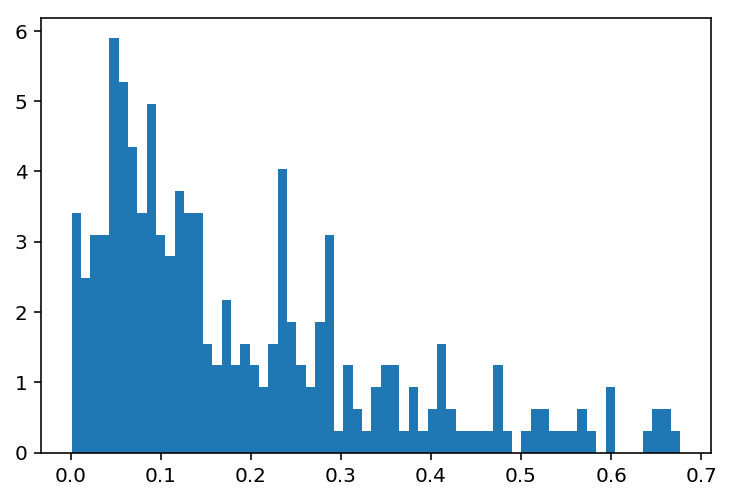

In [8]:
plt.hist(losses_no_outliers, bins=65,density=True)
plt.show()

In [9]:
np.mean(all_window_loss)

0.22717558288632034

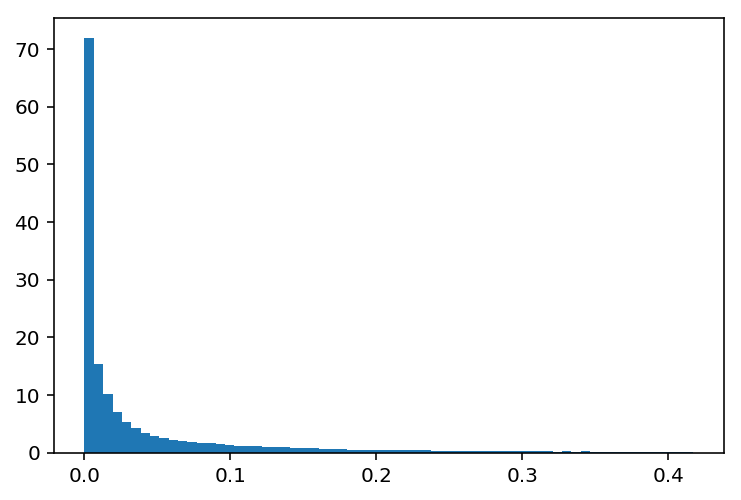

In [10]:
plt.hist(testset_errors, bins=65, density=True)
plt.show()

In [11]:
np.mean(testset_errors)

0.04088255043395008

In [12]:
b = 0

lol=prediction_mean[b,:].detach().numpy()
lol = np.reshape(lol, [w_size,7])

lol_std = prediction_std[b,:].detach().numpy()
lol_std = np.reshape(lol_std, [w_size,7])

lol_true = Y_tensor[b,:].detach().numpy()
lol_true = np.reshape(lol_true, [w_size,7])


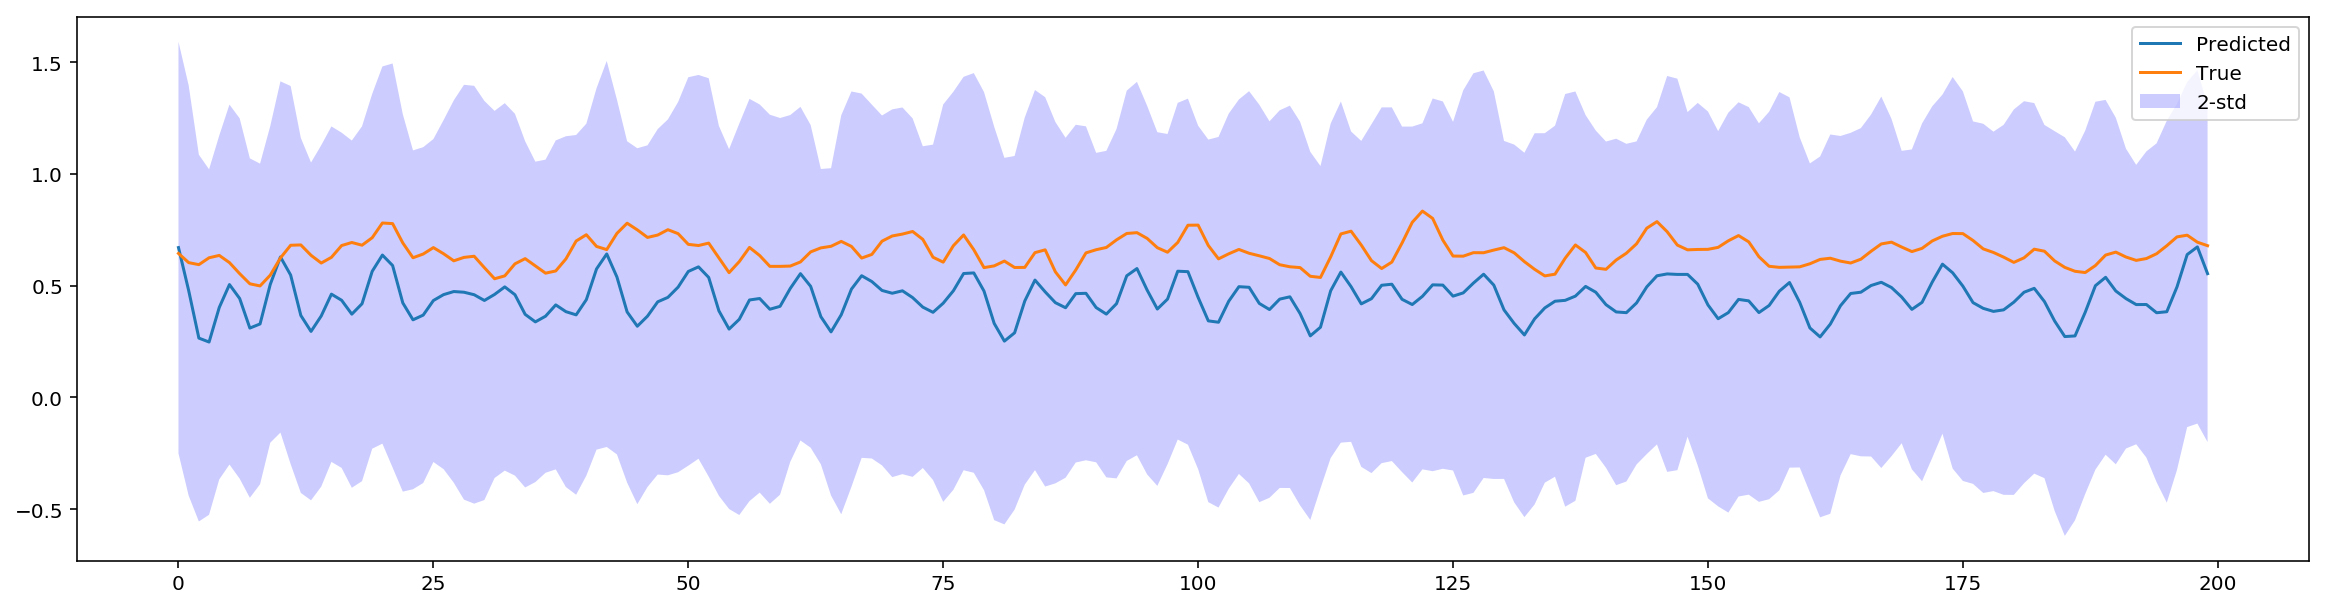

In [13]:
i = 1
plt.figure(figsize=(20,5))
#plt.ylim([-1,1])
plt.plot(lol[:,i], label='Predicted')
plt.fill_between(range(w_size), lol[:,i]-2*lol_std[:,i], lol[:,i]+2*lol_std[:,i], 
                 facecolor='blue', interpolate=True, alpha=0.2, label='2-std')
plt.plot(lol_true[:,i], label='True')
plt.legend()

In [6]:
class z24Dataset(Dataset):
    def __init__(self, filename = '04G03',window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        self.filename = filename
            
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        file_path_vib = '../data/z24_clean/'+self.filename+'_vibrations.npy'
        file_path_env = '../data/z24_clean/'+self.filename+'_env.npy'

        memmap_vib = np.memmap(file_path_vib, dtype=np.float64, mode='r', shape=(65536, 7))
        memmap_env = np.memmap(file_path_env, dtype=np.float64, mode='r', shape=(53,))

        X_environmental = np.array(memmap_env[:])
        X_vibration_window = np.array(memmap_vib[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window.flatten()
    

In [7]:
dataset = z24Dataset(filename = '01C16',window_size=w_size, normalize=True)

dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=16)

loss_criterion = torch.nn.MSELoss(reduce=False)

In [8]:
all_window_loss = []
for X, Y in dataloader:
    X_tensor = X.float().to(device)
    Y_tensor = Y.float()#.to(device)

    batch_size, output_size = Y.shape
    N = 100
    N_predictions = torch.zeros([N, batch_size, output_size])

    for i in range(N):
        N_predictions[i,:,:] = model(X_tensor)

    prediction_mean = torch.mean(N_predictions, dim=0)
    prediction_std = torch.std(N_predictions, dim=0)

    loss_full = loss_criterion(prediction_mean, Y_tensor)

    lower_y = prediction_mean - 2*prediction_std
    upper_y = prediction_mean + 2*prediction_std
    within_lower = Y_tensor > lower_y
    within_upper = Y_tensor < upper_y
    within_range = within_lower & within_upper

    loss_full[within_range] = 0

    for j in range(batch_size):
        window_loss = torch.sum(loss_full[j,:]) / torch.numel(loss_full[j,:])
        all_window_loss.append(window_loss.item())
        
losses_no_outliers = np.sort(all_window_loss)[:int(0.95*len(all_window_loss))]

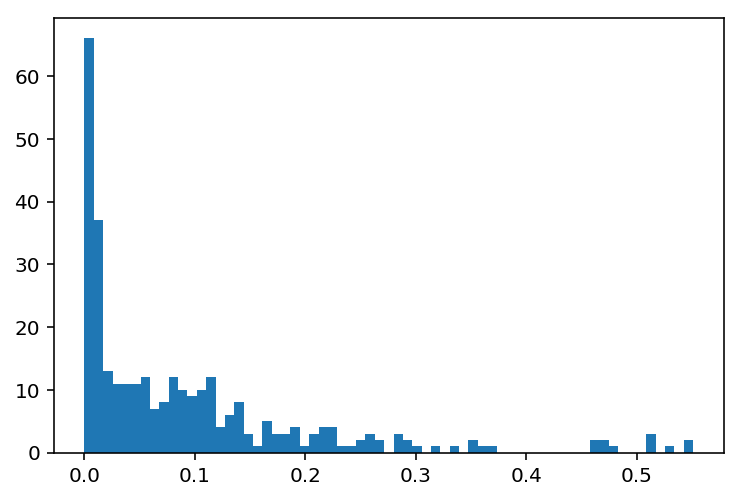

In [9]:
plt.hist(losses_no_outliers, bins=65)
plt.show()

In [10]:
memmap_vib = np.memmap('../data/z24_damage/2/41A22_vibrations.npy', dtype=np.float64, mode='r', shape=(65536, 7))
vibrations = np.array(memmap_vib[:,:])

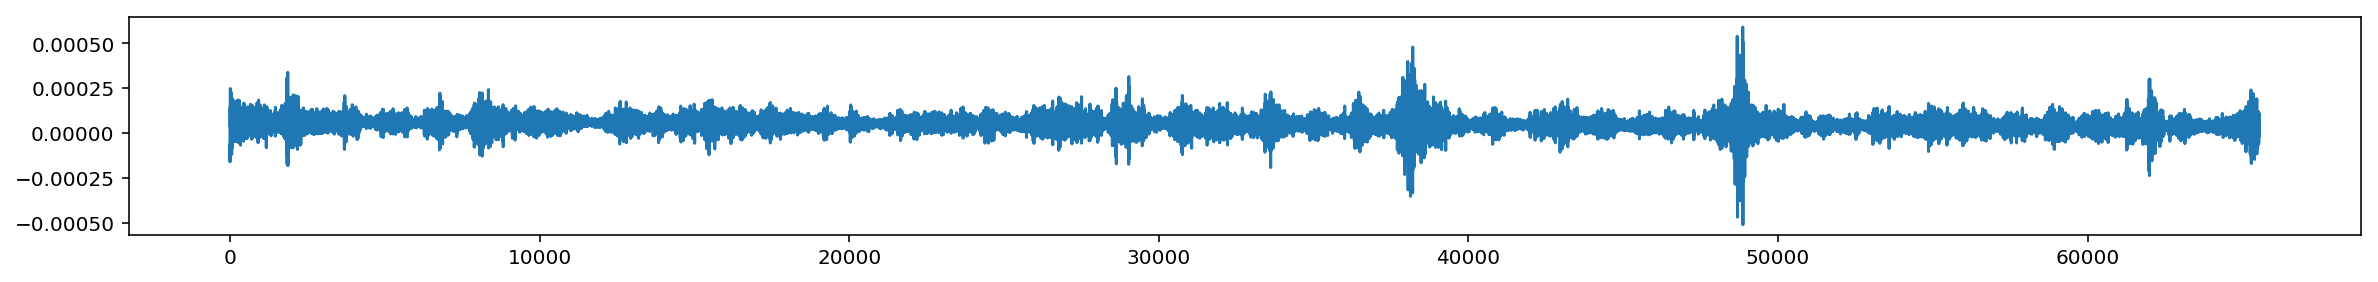

In [11]:
plt.figure(figsize=(20,2))
plt.plot(vibrations[:,5])

In [21]:
test = np.array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.88189188e-05, 1.96207784e-05, 2.44441253e-05,
       2.49242948e-05, 2.49819914e-05, 2.54926617e-05, 2.88652609e-05,
       2.88918236e-05, 2.90031967e-05, 3.02866665e-05, 3.23604363e-05,
       3.25073634e-05, 3.29998111e-05, 3.38772115e-05, 3.39788749e-05,
       3.41366140e-05, 3.41865161e-05, 3.43442189e-05, 3.47564055e-05,
       3.48080466e-05, 3.51402341e-05, 3.77341748e-05, 3.84463565e-05,
       3.88629887e-05, 4.55390727e-05, 4.56176203e-05, 4.72469583e-05,
       5.01276336e-05, 5.02318471e-05, 5.20595386e-05, 5.60957815e-05,
       5.72678291e-05, 5.98532351e-05, 6.00169478e-05, 6.03288099e-05,
       6.05512505e-05, 6.37601770e-05, 6.48489731e-05, 6.53692841e-05,
       6.59785364e-05, 6.60510123e-05, 7.20447279e-05, 7.50701874e-05,
       8.05877862e-05, 8.25894531e-05, 8.45929317e-05, 8.88369468e-05,
       9.40337122e-05, 9.56120784e-05, 9.84996950e-05, 1.03090715e-04,
       1.03302445e-04, 1.03588784e-04, 1.04575869e-04, 1.04769424e-04,
       1.06438420e-04, 1.08018903e-04, 1.13164286e-04, 1.14224618e-04,
       1.20979836e-04, 1.30862914e-04, 1.31034161e-04, 1.31264140e-04,
       1.32326459e-04, 1.36207062e-04, 1.41183235e-04, 1.45536847e-04,
       1.46835562e-04, 1.49794796e-04, 1.53477144e-04, 1.59718227e-04,
       1.61004413e-04, 1.61195596e-04, 1.62381140e-04, 1.64736484e-04,
       1.67697566e-04, 1.73567430e-04, 1.74501169e-04, 1.74682209e-04,
       1.85388053e-04, 1.87340484e-04, 1.88373029e-04, 1.97736896e-04,
       1.98852722e-04, 2.01894974e-04, 2.06965677e-04, 2.07137273e-04,
       2.13471911e-04, 2.13954278e-04, 2.15735796e-04, 2.18659537e-04,
       2.21559472e-04, 2.24596180e-04, 2.31015263e-04, 2.33974803e-04,
       2.38155451e-04, 2.48219469e-04, 2.50521436e-04, 2.52837723e-04,
       2.58268439e-04, 2.58474465e-04, 2.58610555e-04, 2.58901680e-04,
       2.60239322e-04, 2.63149821e-04, 2.63804861e-04, 2.64642440e-04,
       2.69609096e-04, 2.74392019e-04, 2.78370280e-04, 2.85814371e-04,
       2.86614755e-04, 2.89047486e-04, 2.91268108e-04, 2.91524571e-04,
       3.03440902e-04, 3.08550923e-04, 3.14507401e-04, 3.20232561e-04,
       3.25482455e-04, 3.28183523e-04, 3.30604409e-04, 3.35590157e-04,
       3.45729000e-04, 3.47383437e-04, 3.48571892e-04, 3.49194685e-04,
       3.61645943e-04, 3.67178989e-04, 3.79648962e-04, 3.84712766e-04,
       3.85159248e-04, 3.88766697e-04, 3.98501783e-04, 4.33064153e-04,
       4.39633441e-04, 4.42307239e-04, 4.43529920e-04, 4.55999631e-04,
       4.62428405e-04, 4.71566193e-04, 4.75337176e-04, 4.96844412e-04,
       5.04746335e-04, 5.25353826e-04, 5.34126943e-04, 5.35843486e-04,
       5.36773936e-04, 5.43099712e-04, 5.73467987e-04, 5.74334641e-04,
       5.82477951e-04, 5.90849202e-04, 5.92141005e-04, 5.97603561e-04,
       5.97608800e-04, 6.08153001e-04, 6.09115639e-04, 6.13827724e-04,
       6.21626619e-04, 6.23254629e-04, 6.30755967e-04, 6.37615856e-04,
       6.40652550e-04, 6.51745533e-04, 6.54434960e-04, 6.89343840e-04,
       7.12678884e-04, 7.23186706e-04, 7.23698991e-04, 7.32415589e-04,
       7.44119519e-04, 7.57254253e-04, 7.67483958e-04, 7.68855796e-04,
       7.69034436e-04, 7.71464605e-04, 7.75291410e-04, 7.79320486e-04,
       7.80108676e-04, 8.13959516e-04, 8.15369829e-04, 8.15489911e-04,
       8.26875155e-04, 8.47104879e-04, 8.64082132e-04, 8.87666014e-04,
       9.00091371e-04, 9.07295092e-04, 9.17721656e-04, 9.18931619e-04,
       9.21527855e-04, 9.24693362e-04, 9.39408550e-04, 9.42581042e-04,
       9.59001016e-04, 9.64332896e-04, 9.77186952e-04, 1.00385014e-03,
       1.05568336e-03, 1.05692178e-03, 1.09770824e-03, 1.10018498e-03,
       1.12026243e-03, 1.12272403e-03, 1.12400495e-03, 1.17537065e-03,
       1.17594656e-03, 1.17797789e-03, 1.18684222e-03, 1.19830808e-03,
       1.20484224e-03, 1.21256767e-03, 1.22821599e-03, 1.23395037e-03,
       1.24281342e-03, 1.24438910e-03, 1.25900714e-03, 1.26705982e-03,
       1.28030032e-03, 1.29973365e-03, 1.31684402e-03, 1.33534556e-03,
       1.34500791e-03, 1.38852524e-03, 1.39455311e-03, 1.39742962e-03,
       1.44685677e-03, 1.47170643e-03, 1.47614919e-03, 1.51647360e-03,
       1.52216130e-03, 1.52629917e-03, 1.52752036e-03, 1.61744992e-03,
       1.62678398e-03, 1.62818539e-03, 1.68065261e-03, 1.71354774e-03,
       1.74889190e-03, 1.79356674e-03, 1.82699866e-03, 1.85518211e-03,
       1.90930348e-03, 1.97154703e-03, 1.99514930e-03, 2.04168493e-03,
       2.06743670e-03, 2.21443595e-03, 2.25224462e-03, 2.27165385e-03,
       2.28413590e-03, 2.34982907e-03, 2.37154239e-03, 2.39150738e-03,
       2.40484602e-03, 2.41006445e-03, 2.42922688e-03, 2.52269534e-03,
       2.56040459e-03, 2.56421207e-03, 2.62256735e-03, 2.70945951e-03,
       2.72329268e-03, 2.72860704e-03, 2.73618242e-03, 2.86473962e-03,
       2.92639760e-03, 2.96356855e-03, 3.09219328e-03, 3.30876210e-03,
       3.33248382e-03, 3.48672364e-03, 3.52250412e-03, 3.55698145e-03,
       3.63335549e-03, 3.80610698e-03, 3.84904444e-03, 3.90138291e-03,
       4.10510879e-03, 4.20786534e-03, 4.27730754e-03, 4.47634840e-03,
       4.58440045e-03, 4.67630429e-03, 5.19811641e-03, 5.53271035e-03,
       5.72681008e-03, 6.01143623e-03])

(array([177.,  55.,  30.,  14.,  14.,   6.,   6.,   4.,   1.,   3.]),
 array([0.        , 0.00060114, 0.00120229, 0.00180343, 0.00240457,
        0.00300572, 0.00360686, 0.00420801, 0.00480915, 0.00541029,
        0.00601144]),
 <a list of 10 Patch objects>)

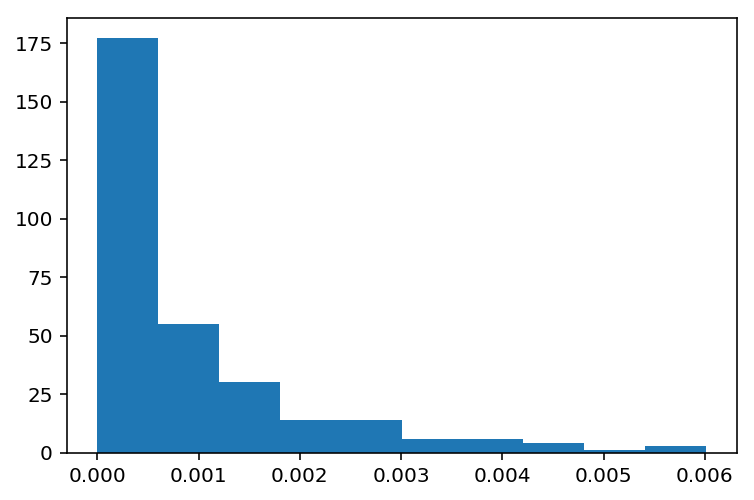

In [22]:
plt.hist(test)

In [23]:
max(test)

0.00601143623

In [24]:
testset01C14 = np.array([1.60643922e-05, 2.30839636e-04, 2.54736486e-04, 3.64107225e-04,
       4.03434155e-04, 4.64303157e-04, 5.19014953e-04, 7.79289345e-04,
       9.10718343e-04, 9.89153748e-04, 9.92691726e-04, 1.05976034e-03,
       1.14882912e-03, 1.18514325e-03, 1.36790331e-03, 1.45409605e-03,
       1.45692087e-03, 1.49087154e-03, 1.81139924e-03, 1.82589446e-03,
       1.86030264e-03, 1.95599254e-03, 2.13261717e-03, 2.28284951e-03,
       2.30742549e-03, 2.31357082e-03, 2.36287713e-03, 2.44440720e-03,
       2.60758377e-03, 2.86813523e-03, 2.92022596e-03, 2.92057218e-03,
       3.03855888e-03, 3.21768690e-03, 3.39831482e-03, 3.47348792e-03,
       3.50973289e-03, 3.88806849e-03, 4.18262510e-03, 4.22807131e-03,
       4.29065898e-03, 4.38755564e-03, 4.98621957e-03, 5.00442972e-03,
       5.07069239e-03, 5.11726504e-03, 5.13039576e-03, 5.14112413e-03,
       5.20202005e-03, 5.91641618e-03, 6.06200146e-03, 6.37340685e-03,
       6.67338632e-03, 6.96631102e-03, 6.99723233e-03, 7.21239857e-03,
       7.25511229e-03, 7.35338964e-03, 7.46328896e-03, 7.57845957e-03,
       7.59925926e-03, 8.17396864e-03, 8.17605667e-03, 8.77956767e-03,
       8.89759976e-03, 9.05198231e-03, 9.23836417e-03, 9.58846975e-03,
       9.61731002e-03, 9.85456072e-03, 9.86365974e-03, 9.96973552e-03,
       1.07468637e-02, 1.07657490e-02, 1.11386012e-02, 1.18237156e-02,
       1.19068557e-02, 1.21426294e-02, 1.23880291e-02, 1.24943824e-02,
       1.25272218e-02, 1.28115611e-02, 1.28440335e-02, 1.34066716e-02,
       1.34220123e-02, 1.39227435e-02, 1.44265434e-02, 1.45169506e-02,
       1.52324755e-02, 1.55275818e-02, 1.56442821e-02, 1.62070785e-02,
       1.67103354e-02, 1.67774223e-02, 1.72722712e-02, 1.73022281e-02,
       1.75307821e-02, 1.80977788e-02, 1.85422674e-02, 1.90783516e-02,
       1.90970581e-02, 1.92725025e-02, 1.95587818e-02, 1.96993686e-02,
       2.00465731e-02, 2.04083472e-02, 2.05422286e-02, 2.14794520e-02,
       2.19709687e-02, 2.20371634e-02, 2.21068375e-02, 2.23284569e-02,
       2.27152109e-02, 2.38510296e-02, 2.41095647e-02, 2.42640134e-02,
       2.44399514e-02, 2.51385272e-02, 2.52801180e-02, 2.56896541e-02,
       2.60936245e-02, 2.64406558e-02, 2.78420448e-02, 2.83943471e-02,
       2.85617728e-02, 2.86108069e-02, 2.87118591e-02, 3.03298924e-02,
       3.03929187e-02, 3.03994976e-02, 3.11559383e-02, 3.13519165e-02,
       3.19462530e-02, 3.19743380e-02, 3.31345983e-02, 3.33715491e-02,
       3.41020077e-02, 3.48869972e-02, 3.52344923e-02, 3.52399796e-02,
       3.55474167e-02, 3.69561352e-02, 3.72661725e-02, 3.72753590e-02,
       3.77651379e-02, 3.81027758e-02, 3.81965376e-02, 3.83114703e-02,
       3.87778319e-02, 3.89630906e-02, 3.94416228e-02, 4.17689383e-02,
       4.24614735e-02, 4.28018011e-02, 4.43950482e-02, 4.49471734e-02,
       4.60634604e-02, 4.61568795e-02, 4.82949950e-02, 4.86971773e-02,
       5.15241884e-02, 5.42084649e-02, 5.46767861e-02, 5.55578619e-02,
       5.64945340e-02, 5.66895716e-02, 5.68937846e-02, 5.84375374e-02,
       5.88175729e-02, 5.90407848e-02, 5.99095486e-02, 6.06852062e-02,
       6.16513379e-02, 6.20603412e-02, 6.37721643e-02, 6.58875257e-02,
       6.59900084e-02, 6.68532923e-02, 6.72404021e-02, 6.77043200e-02,
       6.80223852e-02, 6.98600784e-02, 7.05118477e-02, 7.09587038e-02,
       7.43045509e-02, 7.50161558e-02, 7.66906589e-02, 7.79414177e-02,
       7.82778636e-02, 7.88944587e-02, 7.98850060e-02, 8.04427415e-02,
       8.13544169e-02, 8.23451802e-02, 8.26977342e-02, 8.44461173e-02,
       8.59276950e-02, 8.73267874e-02, 8.81654099e-02, 8.82838741e-02,
       8.85958448e-02, 9.00323093e-02, 9.00417790e-02, 9.10004824e-02,
       9.11570042e-02, 9.31172967e-02, 9.32209641e-02, 9.52456370e-02,
       9.57635194e-02, 9.81287062e-02, 9.86136422e-02, 9.92684066e-02,
       1.04818016e-01, 1.06405161e-01, 1.06427677e-01, 1.06883347e-01,
       1.06927134e-01, 1.08210996e-01, 1.09999806e-01, 1.11331828e-01,
       1.14578202e-01, 1.14826374e-01, 1.15203463e-01, 1.15443245e-01,
       1.15838200e-01, 1.16440319e-01, 1.17528699e-01, 1.18313208e-01,
       1.21168964e-01, 1.24500766e-01, 1.25375599e-01, 1.26810566e-01,
       1.28700808e-01, 1.29437745e-01, 1.29793152e-01, 1.29891112e-01,
       1.31878257e-01, 1.32125467e-01, 1.33058429e-01, 1.33081868e-01,
       1.35317340e-01, 1.41278028e-01, 1.41965196e-01, 1.42753288e-01,
       1.45256102e-01, 1.45935506e-01, 1.48372024e-01, 1.48877159e-01,
       1.51176944e-01, 1.52276769e-01, 1.52860463e-01, 1.55993834e-01,
       1.59470111e-01, 1.62050769e-01, 1.63575828e-01, 1.65115282e-01,
       1.65679708e-01, 1.67404667e-01, 1.73300982e-01, 1.75347432e-01,
       1.75979331e-01, 1.79652333e-01, 1.79997772e-01, 1.82160348e-01,
       1.82199538e-01, 1.85167536e-01, 1.85842350e-01, 1.86651692e-01,
       1.87523395e-01, 1.93998069e-01, 1.94722980e-01, 1.96703672e-01,
       1.99868768e-01, 2.03415632e-01, 2.05907181e-01, 2.09943309e-01,
       2.11634114e-01, 2.12685585e-01, 2.19510362e-01, 2.20225394e-01,
       2.22836435e-01, 2.45063558e-01, 2.56693631e-01, 2.56948560e-01,
       2.59630293e-01, 2.65715778e-01, 2.80128986e-01, 2.93454379e-01,
       3.08581710e-01, 3.13324511e-01, 3.27728868e-01, 3.34695309e-01,
       3.72106016e-01, 3.91988784e-01, 4.05238211e-01, 4.17567611e-01,
       4.21446890e-01, 4.39958006e-01, 4.43861693e-01, 4.62052882e-01,
       4.94674981e-01, 5.30700743e-01, 5.33299744e-01, 5.42045116e-01,
       6.14762247e-01, 6.42987013e-01, 7.24472702e-01, 7.43288040e-01,
       7.43698835e-01, 7.71520972e-01])

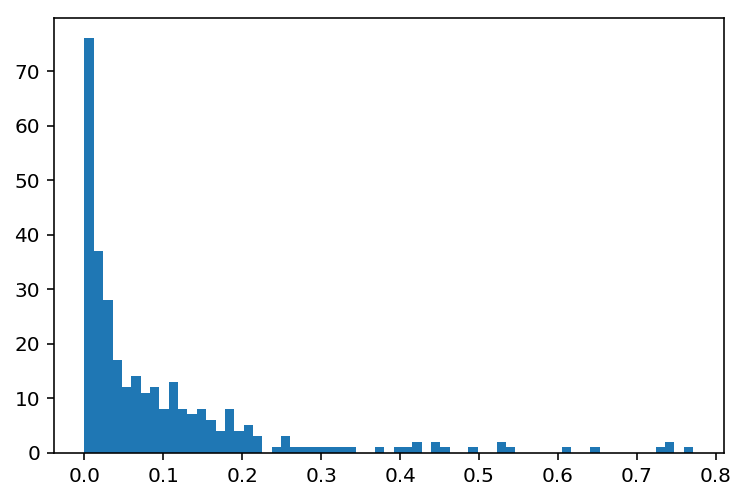

In [27]:
plt.hist(testset01C14, bins=65)
plt.show()

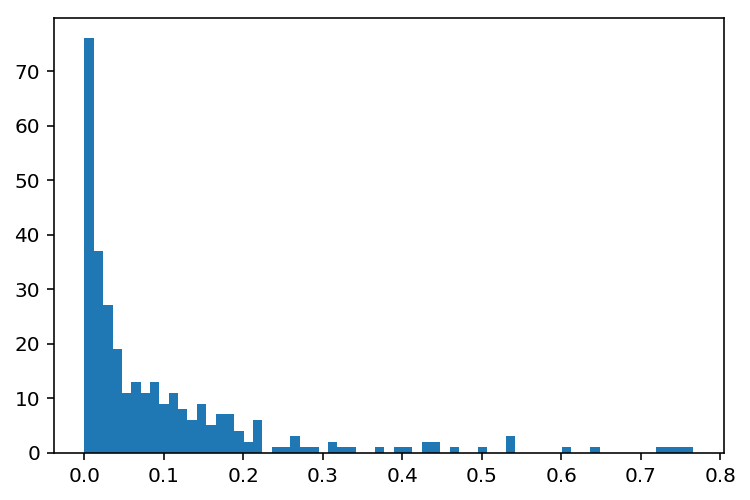

In [28]:
plt.hist(losses_no_outliers, bins=65)
plt.show()

In [25]:
testset01C14.max()

0.771520972

In [12]:
total = np.load('../tools/testset_error_distribution_shallow.npy')

In [13]:
max(total)

0.4169371724128723

In [14]:
np.mean(total)

0.04088255043395008

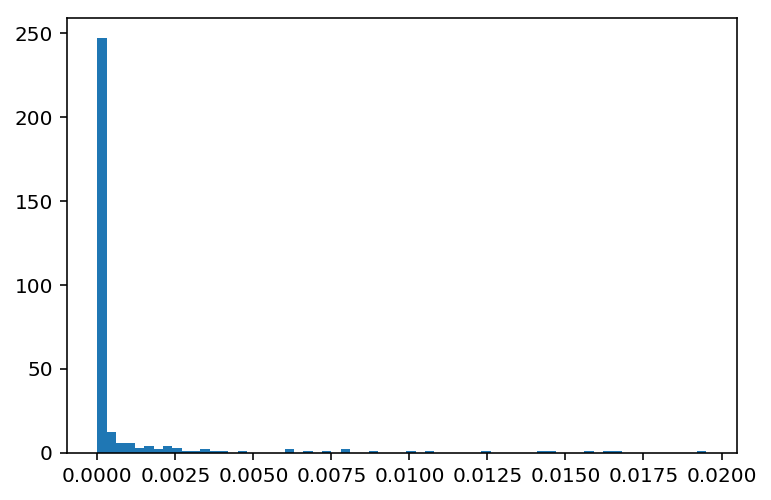

In [15]:
dataset = z24Dataset(window_size=w_size, normalize=True)

dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=16)

loss_criterion = torch.nn.MSELoss(reduce=False)

all_window_loss = []
for X, Y in dataloader:
    X_tensor = X.float().to(device)
    Y_tensor = Y.float()#.to(device)

    batch_size, output_size = Y.shape
    N = 100
    N_predictions = torch.zeros([N, batch_size, output_size])

    for i in range(N):
        N_predictions[i,:,:] = model(X_tensor)

    prediction_mean = torch.mean(N_predictions, dim=0)
    prediction_std = torch.std(N_predictions, dim=0)

    loss_full = loss_criterion(prediction_mean, Y_tensor)

    lower_y = prediction_mean - 2*prediction_std
    upper_y = prediction_mean + 2*prediction_std
    within_lower = Y_tensor > lower_y
    within_upper = Y_tensor < upper_y
    within_range = within_lower & within_upper

    loss_full[within_range] = 0

    for j in range(batch_size):
        window_loss = torch.sum(loss_full[j,:]) / torch.numel(loss_full[j,:])
        all_window_loss.append(window_loss.item())
        
losses_no_outliers = np.sort(all_window_loss)[:int(0.95*len(all_window_loss))]

plt.hist(losses_no_outliers, bins=65)
plt.show()

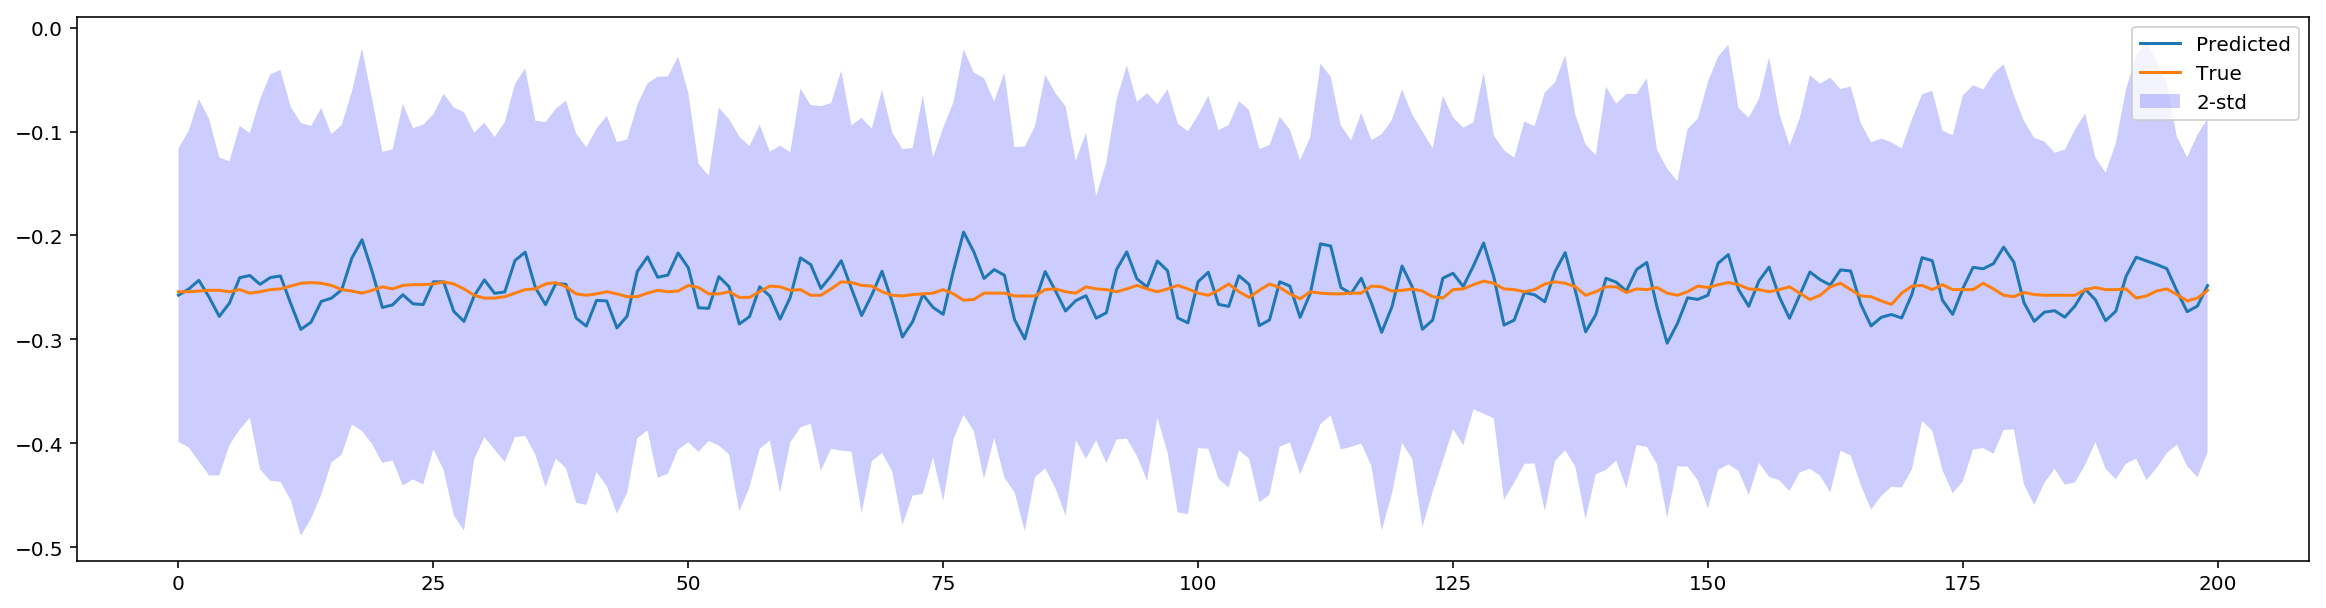

In [16]:
b = 10

lol=prediction_mean[b,:].detach().numpy()
lol = np.reshape(lol, [w_size,7])

lol_std = prediction_std[b,:].detach().numpy()
lol_std = np.reshape(lol_std, [w_size,7])

lol_true = Y_tensor[b,:].detach().numpy()
lol_true = np.reshape(lol_true, [w_size,7])

i = 3
plt.figure(figsize=(20,5))
#plt.ylim([-1,1])
plt.plot(lol[:,i], label='Predicted')
plt.fill_between(range(w_size), lol[:,i]-2*lol_std[:,i], lol[:,i]+2*lol_std[:,i], 
                 facecolor='blue', interpolate=True, alpha=0.2, label='2-std')
plt.plot(lol_true[:,i], label='True')
plt.legend()

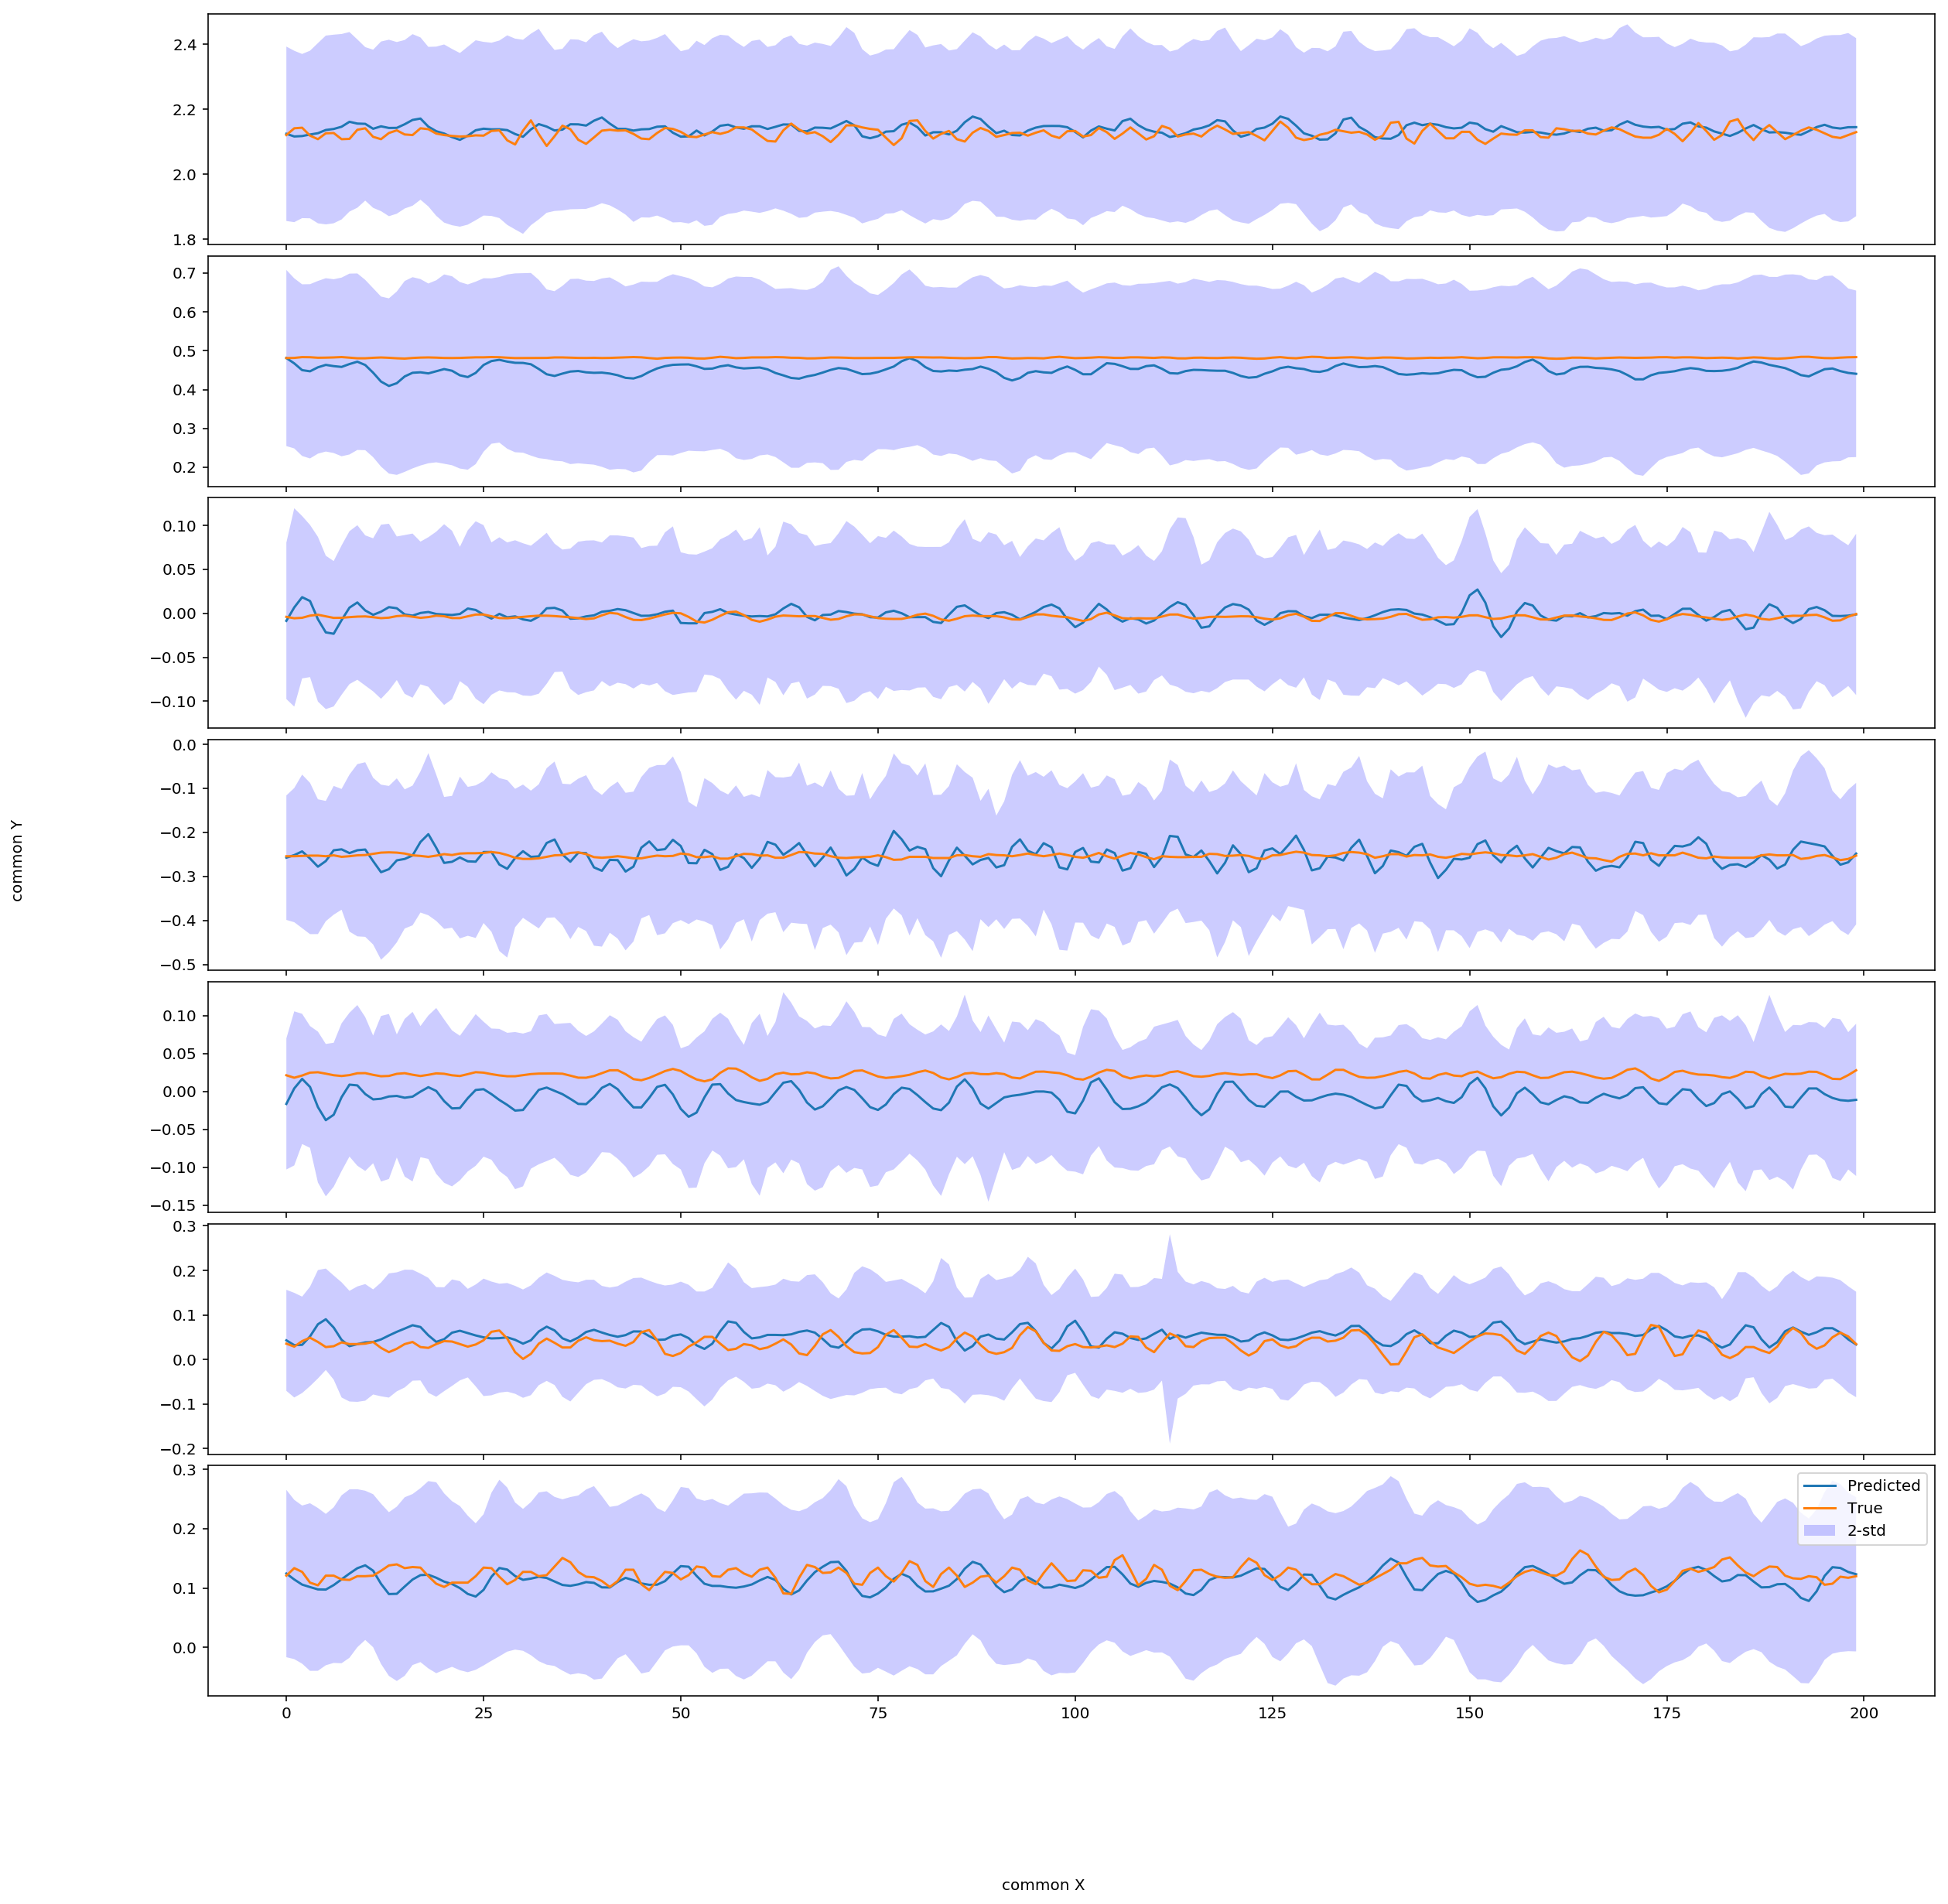

In [17]:
fig, ax = plt.subplots(7, sharex=True, squeeze=True,figsize=(20,20))
plt.title('Healthy test sample 01G05')
for i in range(7):
    ax = plt.subplot(7,1,i+1)
    ax.plot(lol[:,i], label='Predicted')
    plt.fill_between(range(w_size), lol[:,i]-2*lol_std[:,i], lol[:,i]+2*lol_std[:,i], 
                 facecolor='blue', interpolate=True, alpha=0.2, label='2-std')
    plt.plot(lol_true[:,i], label='True')
plt.legend()
#plt.xlabel('Time [ms]')
#plt.ylabel('Normalized acceleration')
fig.text(0.5, 0.04, 'common X', va='center', ha='center', )
fig.text(0.04, 0.5, 'common Y', va='center', ha='center', rotation='vertical', )
plt.subplots_adjust(wspace=0.5, hspace=0.05)
#plt.savefig('damagecase_7_predictions40C07.pdf')